<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Read synthetic population data**

In [73]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_people = 'franklin/microdata/franklin_peoplev0.csv'
data_people = pd.read_csv(filename_people)
data_people['GEOID10'] = data_people['GEOID10'].astype(str)
data_people['BGID10'] = data_people['GEOID10'].str[:12]
data_people['TRACTID10'] = data_people['GEOID10'].str[:11]
data_people

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,GEOID10,PUMAID,SEX,RAC1P,AGEP,DIS,MSP,MIG,MIL,SCHL,FOD1P,HICOV,PRIVCOV,PUBCOV,PINCP,POVPIP,COW,ESR,SOCP,JWMNP,JWRIP,JWTRNS,HouseholdID,lon,lat,BGID10,TRACTID10
0,390490001101001,3904102,1,1,26,2,6.0,3.0,4.0,19.0,NaN,2,2,2,25000.0,495.0,6.0,1.0,1191XX,5.0,1.0,1.0,1,-82.999368,40.054253,390490001101,39049000110
1,390490001101001,3904102,2,9,26,2,6.0,3.0,4.0,19.0,NaN,1,1,2,20000.0,162.0,1.0,1.0,37201X,5.0,2.0,1.0,1,-82.999368,40.054253,390490001101,39049000110
2,390490001101002,3904102,2,1,1,2,NaN,3.0,NaN,NaN,NaN,2,2,2,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4,-83.002695,40.060864,390490001101,39049000110
3,390490001101002,3904102,2,1,4,2,NaN,1.0,NaN,2.0,NaN,1,1,2,NaN,501.0,NaN,NaN,NaN,NaN,NaN,NaN,5,-83.001629,40.060899,390490001101,39049000110
4,390490001101002,3904102,2,1,8,2,NaN,1.0,NaN,4.0,NaN,1,1,2,NaN,491.0,NaN,NaN,NaN,NaN,NaN,NaN,6,-83.001937,40.060852,390490001101,39049000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138714,390490107001020,3904102,2,1,77,1,3.0,1.0,4.0,19.0,NaN,1,2,1,17200.0,144.0,NaN,6.0,NaN,NaN,NaN,NaN,70,-83.017831,40.065591,390490107001,39049010700
1138715,390490107001020,3904102,1,1,94,2,1.0,1.0,2.0,22.0,5200.0,1,1,1,5200.0,266.0,NaN,6.0,NaN,NaN,NaN,NaN,108,-83.017814,40.062582,390490107001,39049010700
1138716,390490107001020,3904102,2,1,94,1,6.0,1.0,4.0,16.0,NaN,1,2,1,0.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,95,-83.018259,40.064492,390490107001,39049010700
1138717,390499800001027,3904106,1,1,74,2,2.0,1.0,4.0,15.0,NaN,1,1,1,33300.0,221.0,NaN,6.0,NaN,NaN,NaN,NaN,1,-82.879433,40.004085,390499800001,39049980000


#### **Create original histograms**
We consider the query of race (RAC1P) for the purpose of demonstration. Cell uniqueness is presented in this query.

In [74]:
hist1 = pd.crosstab(data_people.GEOID10, data_people.RAC1P)
hist1

RAC1P,1,2,3,4,5,6,7,8,9
GEOID10,,,,,,,,,
390490001101001,1,0,0,0,0,0,0,0,1
390490001101002,45,0,0,0,0,0,0,0,0
390490001101003,51,4,0,0,0,0,0,0,0
390490001101004,48,0,0,0,0,0,0,0,0
390490001101005,51,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...
390490107001015,92,17,0,0,0,0,0,1,2
390490107001016,9,0,0,0,0,0,0,0,0
390490107001017,42,6,0,0,0,9,0,0,0


[(0.0, 10.0)]

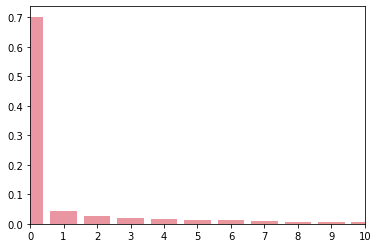

In [75]:
import seaborn as sns

probabilities = hist1.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

#### **Add noises (Zero-concentrated differential privacy)**
There are two core components to the 2020 DAS: noise injection and post-processing. We only focus on the noise injection here. Consistent with the 2020 DAS, discrete Gaussian noise is applied.

Bun, M., & Steinke, T. (2016, November). Concentrated differential privacy: Simplifications, extensions, and lower bounds. In Theory of Cryptography Conference (pp. 635-658). Springer, Berlin, Heidelberg.

Parameters for generating Gaussian noise.

In [76]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0

(0.03765194044422748, 1.8998742342553376)

Probability of generating zero noise and other noises.

In [77]:
import scipy.stats

print(scipy.stats.norm(0, sigma).cdf(0.5) - scipy.stats.norm(0, sigma).cdf(-0.5), 
      scipy.stats.norm(0, sigma).cdf(1.5) - scipy.stats.norm(0, sigma).cdf(0.5),
      scipy.stats.norm(0, sigma).cdf(2.5) - scipy.stats.norm(0, sigma).cdf(1.5),
      scipy.stats.norm(0, sigma).cdf(3.5) - scipy.stats.norm(0, sigma).cdf(2.5), 
      scipy.stats.norm(0, sigma).cdf(8.5) - scipy.stats.norm(0, sigma).cdf(7.5))

0.10913342502468493 0.1051255079831912 0.09396346340685724 0.07793101600369479 0.009953116866908474


Add noise to histogram.

In [78]:
hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
hist2

RAC1P,1,2,3,4,5,6,7,8,9
GEOID10,,,,,,,,,
390490001101001,3.0,2.0,4.0,1.0,-1.0,-1.0,2.0,0.0,5.0
390490001101002,47.0,-3.0,2.0,-8.0,6.0,4.0,-2.0,5.0,4.0
390490001101003,50.0,7.0,-1.0,9.0,8.0,1.0,0.0,-5.0,1.0
390490001101004,52.0,0.0,1.0,-2.0,6.0,4.0,2.0,8.0,7.0
390490001101005,55.0,-1.0,10.0,-2.0,-4.0,-2.0,-1.0,-5.0,7.0
...,...,...,...,...,...,...,...,...,...
390490107001015,91.0,18.0,-7.0,-6.0,-2.0,-3.0,-1.0,0.0,4.0
390490107001016,13.0,-2.0,-10.0,1.0,-3.0,-1.0,-1.0,0.0,0.0
390490107001017,41.0,9.0,-1.0,4.0,-2.0,11.0,-6.0,-2.0,-1.0


####**Cell uniqueness**
Young, C., Martin, D., & Skinner, C. (2009). Geographically intelligent disclosure control for flexible aggregation of census data. International Journal of Geographical Information Science, 23(4), 457-482.

Privacy measure: probability of finding a true unique

In [79]:
# find a true unique
tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
n_tu

653

In [80]:
# uniques after noise injection
u = hist2 == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
n_u

11652

In [81]:
# frequency of finding the true uniques
p_tu = n_tu / n_u
p_tu

0.05604188122210779

Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

$p(TU)=\frac{p(-0.5<=W<=0.5)p(A_1)}{\sum_ip(0.5-i<=W<=1.5-i)p(A_i)}$


$p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [64]:
import scipy.stats

column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.054544768415419304

We also use a Monte Carlo method to calculate the expected frequency (probability) of finding the true uniques. The result is consistent with the theoretical value.

In [65]:
import statistics
import numpy as np

N = 1000    # bootstrap times
p_tus = []

for i in range(N):
    hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
    # find a true unique
    tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2 == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu = n_tu / n_u
    p_tus.append(p_tu)

statistics.mean(p_tus)

0.05450878379766212

####**More on cell uniqueness**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.

#####**Impact of resolutions (aggregation levels)**
We test the probability of finding a true unique at both block group and tract levels. As shown below, as we increase the aggregation level, the probability raises. This is potentially due to the fact that the histogram is less clustered around the small numbers (e.g., 2, 3, 0 that are easily transformed to 1 when adding noises).

Block group.

In [82]:
hist1_bg = pd.crosstab(data_people.BGID10, data_people.RAC1P)
hist1_bg

RAC1P,1,2,3,4,5,6,7,8,9
BGID10,,,,,,,,,
390490001101,1040,14,0,0,0,8,0,3,15
390490001102,814,15,0,0,0,14,0,2,7
390490001103,619,6,0,0,0,4,0,6,9
390490001104,744,5,0,0,0,4,0,1,5
390490001201,758,6,0,0,0,10,0,1,12
...,...,...,...,...,...,...,...,...,...
390490106021,1369,46,0,0,0,39,0,15,23
390490106022,2293,58,0,0,0,154,0,14,41
390490106023,1824,50,0,0,0,209,0,18,35


[(0.0, 10.0)]

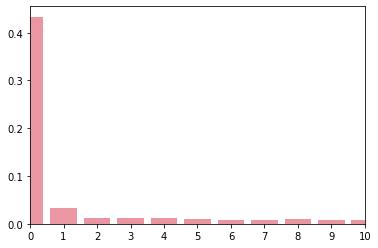

In [83]:
import seaborn as sns

probabilities = hist1_bg.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [67]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 3/4099

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0

(0.012544523054403513, 1.0874367368840445)

In [68]:
import scipy.stats

column_values = hist1_bg[hist1_bg.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.06184121453803658

Tract.

In [31]:
hist1_tr = pd.crosstab(data_people.TRACTID10, data_people.RAC1P)
hist1_tr

RAC1P,1,2,3,4,5,6,7,8,9
TRACTID10,,,,,,,,,
39049000110,3217,40,0,0,0,30,0,12,36
39049000120,3016,44,0,0,1,36,0,6,48
39049000210,2773,51,1,0,0,26,0,8,62
39049000220,3536,31,0,0,0,50,0,20,76
39049000310,2135,739,0,0,0,67,0,55,137
...,...,...,...,...,...,...,...,...,...
39049010500,6499,100,0,0,0,1178,0,28,115
39049010601,3933,127,0,0,0,436,0,30,83
39049010602,5486,154,0,0,0,402,0,47,99


[(0.0, 10.0)]

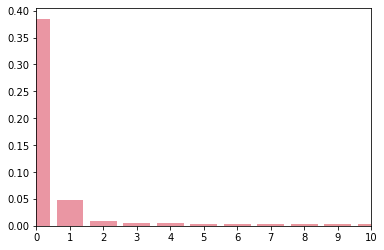

In [ ]:
import seaborn as sns

probabilities = hist1_tr.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [69]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 4/2051

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0

(0.03342759629449049, 1.7880772470489288)

In [70]:
import scipy.stats

column_values = hist1_tr[hist1_tr.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.109321997384347

#####**Impact of extents**

Read block data.

In [84]:
!pip install geopandas
!pip install pysal

In [85]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block['GEOID10'] = data_block['GEOID10'].astype(str)
data_block['BGID10'] = data_block['GEOID10'].str[:12]
data_block['TRACTID10'] = data_block['GEOID10'].str[:11]
data_block.head()

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,OBJECTID_1,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PUMA,Shape_Length,Shape_Area,AREA,geometry,BGID10,TRACTID10
0,1,39,049,006500,4019,390490065004019,Block 4019,G5040,U,19234,U,S,98391,2149,+40.0001827,-083.0802471,3904104,0.016835,1.060361e-05,100537.362702,"POLYGON ((-83.08283 40.00301, -83.08280 40.002...",390490065004,39049006500
1,2,39,049,007812,2017,390490078122017,Block 2017,G5040,U,19234,U,S,0,2575,+40.0376070,-083.0355367,3904105,0.017067,2.716620e-07,2574.303163,"POLYGON ((-83.03954 40.03505, -83.03952 40.035...",390490078122,39049007812
2,3,39,049,008380,3046,390490083803046,Block 3046,G5040,R,,,S,0,1099,+39.8858862,-083.0260845,3904110,0.002871,1.156665e-07,1098.446298,"POLYGON ((-83.02613 39.88562, -83.02617 39.885...",390490083803,39049008380
3,4,39,049,007531,1013,390490075311013,Block 1013,G5040,U,19234,U,S,78927,1630,+40.0527883,-082.9453223,3904106,0.017112,8.502607e-06,80547.837054,"POLYGON ((-82.94881 40.05366, -82.94883 40.053...",390490075311,39049007531
4,5,39,049,007207,1025,390490072071025,Block 1025,G5040,U,19234,U,S,0,1765,+40.1094785,-082.8392880,3904101,0.008204,1.864805e-07,1764.991090,"POLYGON ((-82.83938 40.10938, -82.83945 40.109...",390490072071,39049007207


Find blocks in the most populated tract (largest population density).

In [33]:
total = hist1.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_block_new = data_block.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])
total.head()

,POP,GEOID10
390490001101001,2,390490001101001
390490001101002,45,390490001101002
390490001101003,55,390490001101003
390490001101004,48,390490001101004
390490001101005,55,390490001101005


In [45]:
total_tr = data_block_new.groupby(['TRACTID10'])['POP'].agg('sum').to_frame()
total_tr["TRACTID10"] = total_tr.index.map(str)
total_tr.index.name = None
area_tr = data_block_new.groupby(['TRACTID10'])['AREA'].agg('sum').to_frame()
area_tr["TRACTID10"] = area_tr.index.map(str)
area_tr.index.name = None
popden_tr = total_tr.merge(area_tr[['TRACTID10', 'AREA']], how='left', on=['TRACTID10'])
popden_tr["DEN"] = popden_tr["POP"] / popden_tr["AREA"]
max_index = popden_tr["DEN"].idxmax()
max_id = popden_tr.loc[max_index].at['TRACTID10']
max_id

'39049001810'

Calculate $p(TU)$ based on the selected blocks (only blocks in the most population tract).

In [50]:
data_people_b1 = data_people[data_people["TRACTID10"] == max_id]
hist1_b1 = pd.crosstab(data_people_b1.GEOID10, data_people_b1.RAC1P)
hist1_b1.head()

RAC1P,1,2,3,5,6,8,9
GEOID10,,,,,,,
390490018101000,88,5,0,0,7,2,4
390490018101001,45,0,0,0,8,0,1
390490018101002,338,25,0,0,53,6,15
390490018101003,153,4,0,0,30,0,5
390490018101004,234,7,0,0,40,0,6


[(0.0, 10.0)]

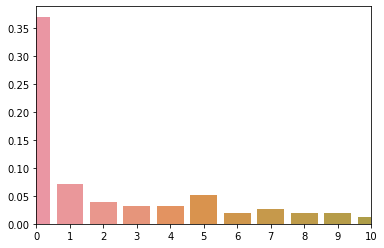

In [51]:
import seaborn as sns

probabilities = hist1_b1.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [71]:
import scipy.stats

column_values = hist1_b1[hist1_b1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_b1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_b1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.12443446484025812

Find the k-nearst neighbors of the selected tract and expand the examined blocks.

####Something else to be deleted

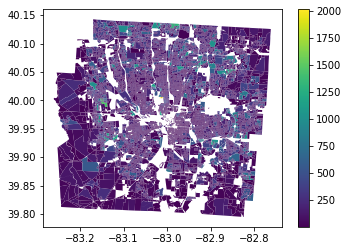

In [24]:
import matplotlib.pyplot as plt

data_block_new['POP_DEN'] = data_block_new['POP'] / data_block_new['AREA']
fig, ax = plt.subplots(1, 1)
data_block_new.plot(column='POP', ax=ax, legend=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


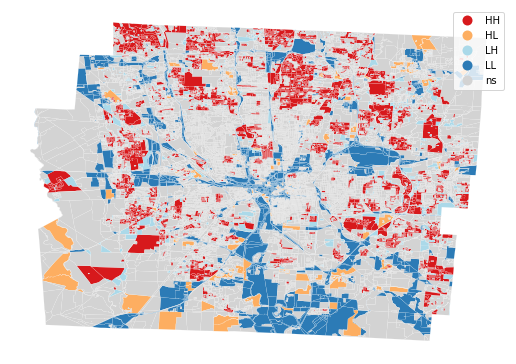

In [27]:
from splot.esda import lisa_cluster
from pysal.lib import weights
from pysal.explore import esda

data_block_new['POP'] = data_block_new['POP'].fillna(0)
# Generate W from the GeoDataFrame
w = weights.Queen.from_dataframe(data_block_new)
# Row-standardization
w.transform = 'R'

moran_loc = esda.moran.Moran_Local(data_block_new['POP'].values, w)
lisa_cluster(moran_loc, data_block_new, p=0.05, figsize = (9,9))
plt.show()

#####**Distribution of $n(A_1)$**

Read block data.

In [ ]:
!pip install geopandas
!pip install pysal

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block.head()

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,OBJECTID_1,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PUMA,Shape_Length,Shape_Area,AREA,geometry
0,1,39,049,006500,4019,390490065004019,Block 4019,G5040,U,19234,U,S,98391,2149,+40.0001827,-083.0802471,3904104,0.016835,1.060361e-05,100537.362702,"POLYGON ((-83.08283 40.00301, -83.08280 40.002..."
1,2,39,049,007812,2017,390490078122017,Block 2017,G5040,U,19234,U,S,0,2575,+40.0376070,-083.0355367,3904105,0.017067,2.716620e-07,2574.303163,"POLYGON ((-83.03954 40.03505, -83.03952 40.035..."
2,3,39,049,008380,3046,390490083803046,Block 3046,G5040,R,,,S,0,1099,+39.8858862,-083.0260845,3904110,0.002871,1.156665e-07,1098.446298,"POLYGON ((-83.02613 39.88562, -83.02617 39.885..."
3,4,39,049,007531,1013,390490075311013,Block 1013,G5040,U,19234,U,S,78927,1630,+40.0527883,-082.9453223,3904106,0.017112,8.502607e-06,80547.837054,"POLYGON ((-82.94881 40.05366, -82.94883 40.053..."
4,5,39,049,007207,1025,390490072071025,Block 1025,G5040,U,19234,U,S,0,1765,+40.1094785,-082.8392880,3904101,0.008204,1.864805e-07,1764.991090,"POLYGON ((-82.83938 40.10938, -82.83945 40.109..."


Count cell uniques in the original histograms, that is, $n(A_1)$.

In [ ]:
uniques = (hist1 == 1).sum(axis=1).to_frame()
uniques["GEOID10"] = uniques.index.map(str)
uniques = uniques.rename(columns={uniques.columns[0]: "UNI"})
uniques.index.name = None
uniques.head()

,UNI,GEOID10
390490001101001,2,390490001101001
390490001101002,0,390490001101002
390490001101003,0,390490001101003
390490001101004,0,390490001101004
390490001101005,0,390490001101005


Visualize the distribution of $n(A_1)$ in geospace. It seems like cell uniques are more likely to cluster in small blocks (center of the city).

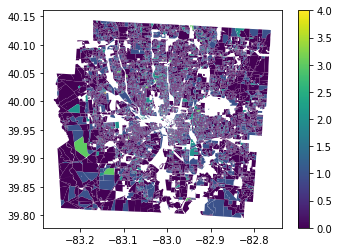

In [ ]:
import matplotlib.pyplot as plt

data_block_new = data_block.merge(uniques[['GEOID10', 'UNI']], how='left', on=['GEOID10'])
fig, ax = plt.subplots(1, 1)
data_block_new.plot(column='UNI', ax=ax, legend=True)

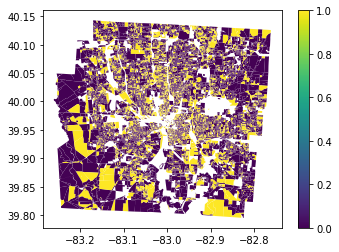

In [ ]:
import matplotlib.pyplot as plt

data_block_new.loc[data_block_new['UNI'] == 0, 'UNI_CAT'] = 0
data_block_new.loc[(data_block_new['UNI'] >= 1) & (data_block_new['UNI'] <= 4), 'UNI_CAT'] = 1
fig, ax = plt.subplots(1, 1)
data_block_new.plot(column='UNI_CAT', ax=ax, legend=True)

Calculate local Moran's I.

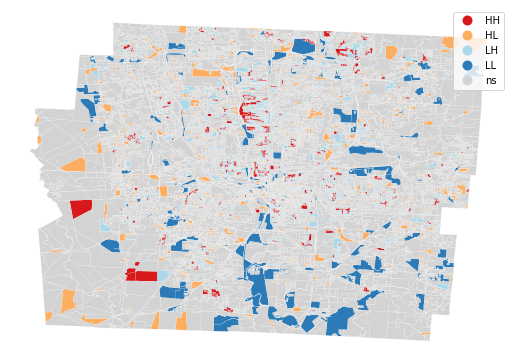

In [ ]:
from splot.esda import lisa_cluster
from pysal.lib import weights
from pysal.explore import esda

data_block_new['UNI'] = data_block_new['UNI'].fillna(0)
# Generate W from the GeoDataFrame
w = weights.Queen.from_dataframe(data_block_new)
# Row-standardization
w.transform = 'R'

moran_loc = esda.moran.Moran_Local(data_block_new['UNI'].values, w)
lisa_cluster(moran_loc, data_block_new, p=0.05, figsize = (9,9))
plt.show()

####**Check LP metric**
Wieland, S. C., Cassa, C. A., Mandl, K. D., & Berger, B. (2008). Revealing the spatial distribution of a disease while preserving privacy. Proceedings of the National Academy of Sciences, 105(46), 17608-17613.

Privacy measure: probability that any chosen member of the population belong to the target population